## Initialization: 
- pip3 install pm4py
- do a system wide install of graphviz: https://www.graphviz.org/download/

In [1]:
import pandas as pd
import os
import time

import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.visualization.petrinet import visualizer as pn_vis_factory
from pm4py.objects.petri.exporter.exporter import pnml as pnml_exporter
from graphviz import *

# Log Filtering & Statistics
from pm4py.algo.filtering.log.cases import case_filter
from pm4py.algo.filtering.log.variants import variants_filter
from pm4py.statistics.traces.log import case_statistics

# Conformance checking
from pm4py.evaluation.replay_fitness import evaluator as replay_fitness_evaluator
from pm4py.evaluation.precision import evaluator as precision_evaluator
from pm4py.evaluation.generalization import evaluator as generalization_evaluator
from pm4py.evaluation.simplicity import evaluator as simplicity_evaluator

# Alpha Miner
from pm4py.algo.discovery.alpha import algorithm as alpha_miner

# IMDFb miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner

# Heuristics miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner

import utils

LOAD_REGULAR_LOG = False

In [2]:
if LOAD_REGULAR_LOG:
    log = xes_importer.apply(utils.PATH_LOG)
else:
    log = utils.load_log()

## [Work in progress] Filter log file
link: http://pm4py.pads.rwth-aachen.de/documentation/filtering-logs/

In [3]:
#traces_total = len(log.traces)
variants_count = case_statistics.get_variant_statistics(log)
variants_count = sorted(variants_count, key=lambda x: x['count'], reverse=True)
# print(variants_count)

In [4]:
filtered_log = case_filter.filter_on_case_performance(log, 12, 8640000)

In [5]:
filtered_log

[]

## 1. Apply alpha miner to discover the process model
- green node = starting point
- orange node = ending point

In [6]:
net, initial_marking, final_marking = alpha_miner.apply(log)

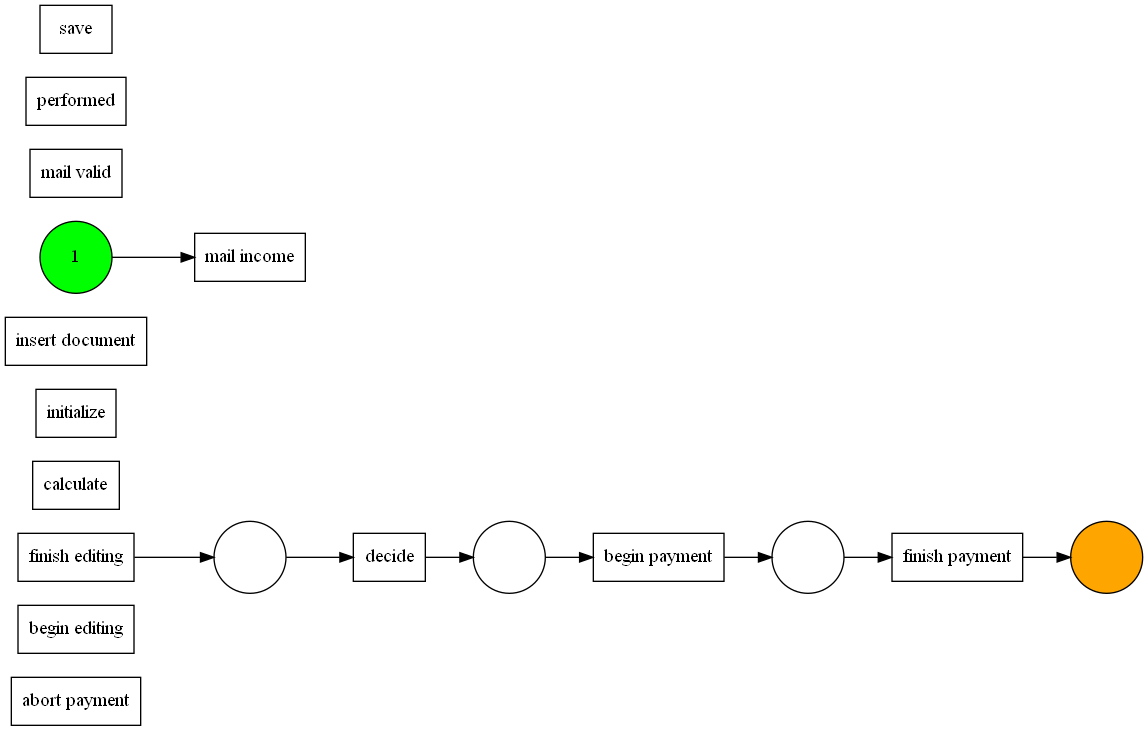

In [7]:
gviz = pn_vis_factory.apply(net, initial_marking, final_marking)
pn_vis_factory.view(gviz)

In [8]:
pnml_exporter.export_net(net, initial_marking, "alpha_miner_petri.pnml")

## Conformance check Alpha Miner
- Fitness: how much of the behavior that was observed in the event log fits the process model
- Precision: how much behavior a process model allows for that was never observed in the event log.
- Generalization: how well a process model generalizes to behavior that is possible in the business process but was never observed in the event log
- Simplicity: (??) complexity of the model vs simplicity

link: https://pm4py.fit.fraunhofer.de/documentation#conformance

In [9]:
import gc
gc.collect()

66

In [10]:
start = time.perf_counter()

# fitness based on toked-based replay
fitness = replay_fitness_evaluator.apply(log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

with open("alpha_miner_results.txt", "w") as file:
    file.write(str(fitness))
    file.write("\n")

print(f"[ Finished writing fitness metric in: {time.perf_counter() - start} sec]")

# collect garbage, will probably fail further functions because the log is loaded in mem
gc.collect()

# precision based on token-based replay
prec = precision_evaluator.apply(log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ALIGN_ETCONFORMANCE)

with open("alpha_miner_results.txt", "w") as file:
    file.write(str(prec))
    file.write("\n")

print(f"[ Finished Precision metric: {time.perf_counter() - start} sec]")

# collect garbage
gc.collect()

# generalization based on token-based replay
gen = generalization_evaluator.apply(log, net, initial_marking, final_marking)

with open("alpha_miner_results.txt", "w") as file:
    file.write(str(gen))
    file.write("\n")

# collect garbage
gc.collect()

print(f"[ Finished Generalization metric: {time.perf_counter() - start} sec]")

# simplicity measured by the inverse arc degree
simp = simplicity_evaluator.apply(net)

with open("alpha_miner_results.txt", "w") as file:
    file.write(str(simp))
    file.write("\n")
print(f"[Finished: {time.perf_counter() - start}]")

[ Finished writing fitness metric in: 0.009019300000000285 sec]
[ Finished Precision metric: 0.2066720000000002 sec]
[ Finished Generalization metric: 0.33930040000000083 sec]
[Finished: 0.3409026000000006]


#### Generalization
Basically, a model is general whether the elements of the model are visited enough often during a replay operation (of the log on the model). A model may be perfectly fitting the log and perfectly precise (for example, reporting the traces of the log as sequential models going from the initial marking to the final marking; a choice is operated at the initial marking). 

#### Simplicity
First of all, we consider the average degree for a place/transition of the Petri net, that is defined as the sum of the number of input arcs and output arcs. If all the places have at least one input arc and output arc, the number is at least 2. Choosing a number k between 0 and infinity, the simplicity based on the inverse arc degree is then defined as 1.0 / (1.0 + max(mean_degree - k, 0)).

In [11]:
results = [fitness, prec, gen, simp]
with open("alpha_miner_results.txt", "w") as file:
    for i in range(4):
        file.write(str(results[i]))
        file.write("\n")

## Interpretation of Alpha miner conformance check

## 2. Inductive Miner Directly Follows algorithm to discover the process model
- link: http://pm4py.pads.rwth-aachen.de/documentation/process-discovery/inductive-miner/

In [12]:
net, initial_marking, final_marking = inductive_miner.apply(log)

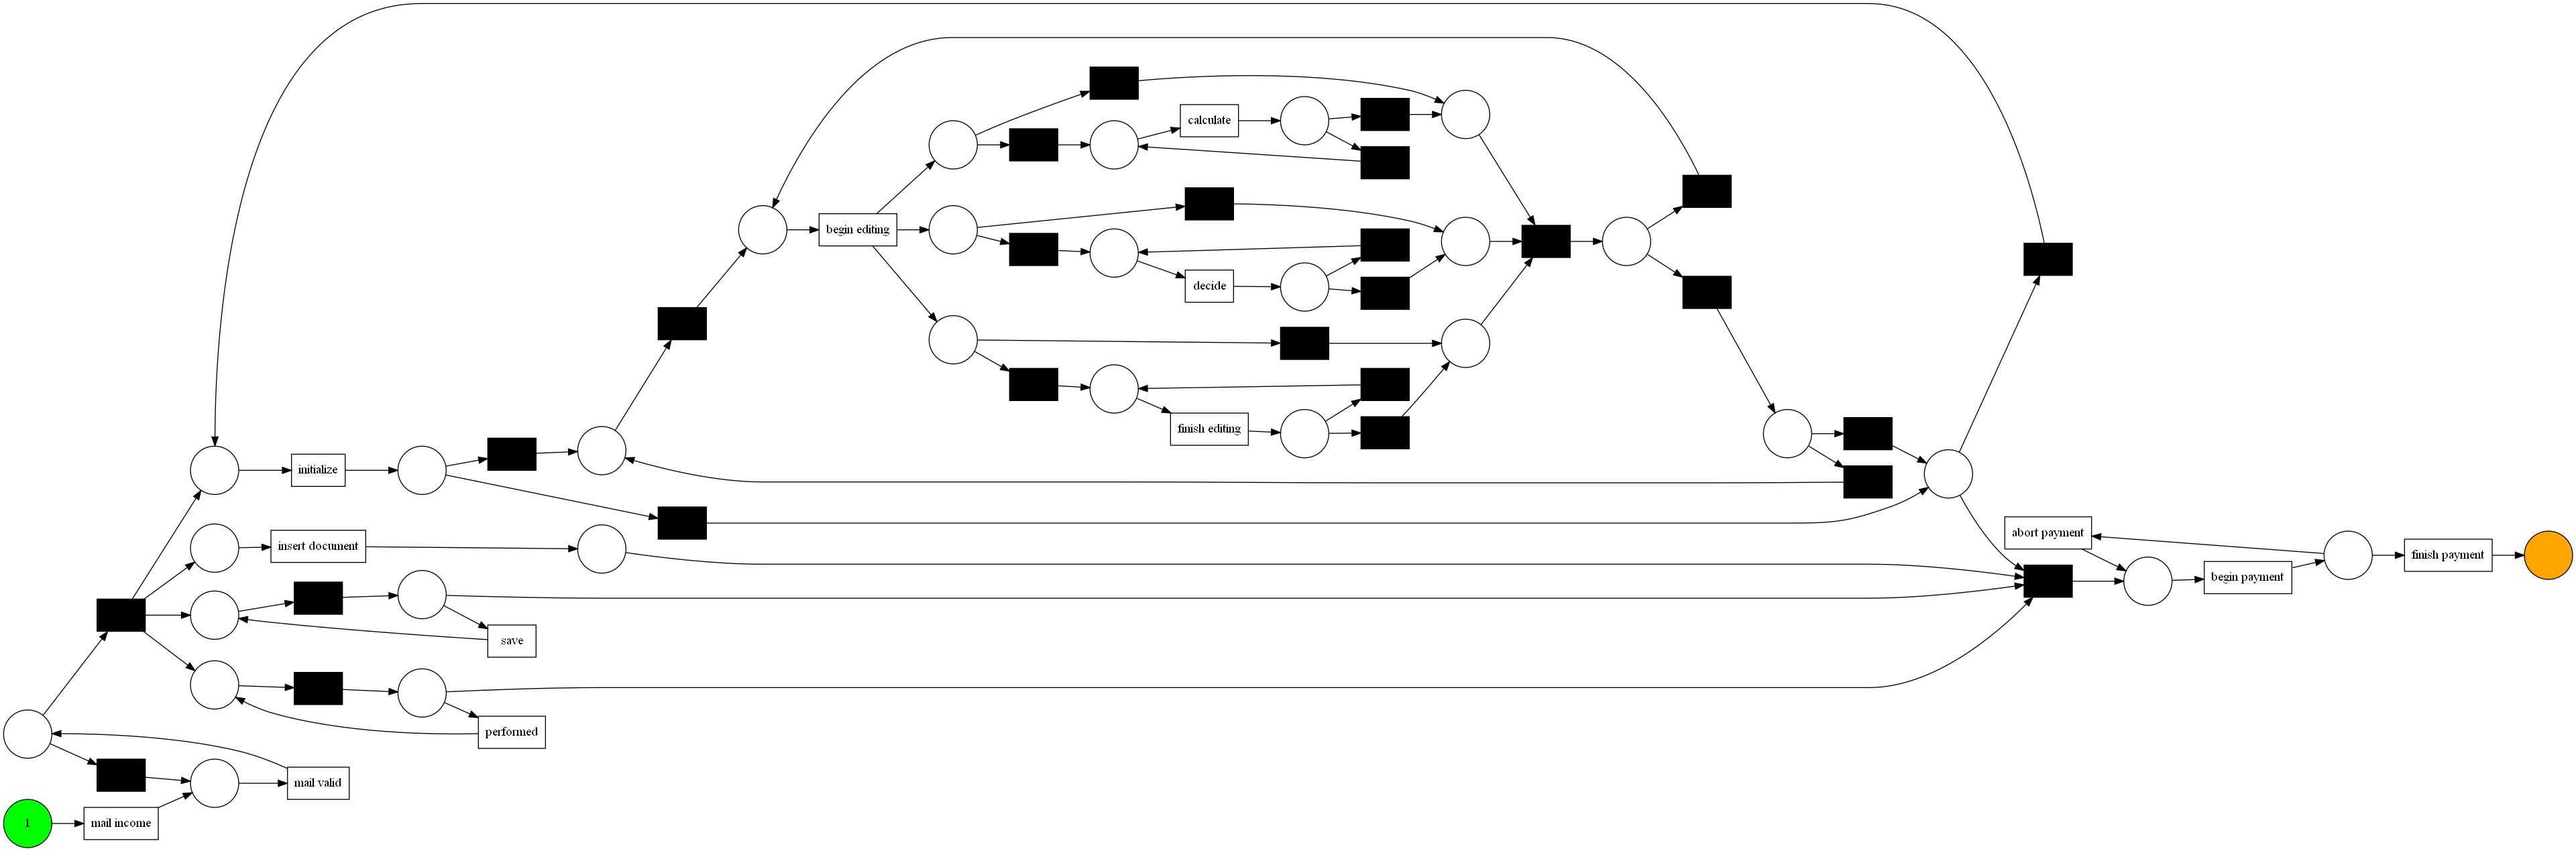

In [13]:
gviz = pn_vis_factory.apply(net, initial_marking, final_marking)
pn_vis_factory.view(gviz)

In [14]:
pnml_exporter.export_net(net, initial_marking, "inductive_miner_petri.pnml")

## Conformance check Inductive Miner Directly Follows algorithm

In [15]:
start = time.perf_counter()

# fitness based on toked-based replay
fitness = replay_fitness_evaluator.apply(log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

print(f"[ Finished Fitness metric in: {time.perf_counter() - start} sec]")

# precision based on token-based replay
prec = precision_evaluator.apply(log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

print(f"[ Finished Precision metric: {time.perf_counter() - start} sec]")

# generalization based on token-based replay
gen = generalization_evaluator.apply(log, net, initial_marking, final_marking)

print(f"[ Finished Generalization metric: {time.perf_counter() - start} sec]")

# simplicity measured by the inverse arc degree
simp = simplicity_evaluator.apply(net)

print(f"[Finished: {time.perf_counter() - start}]")

[ Finished Fitness metric in: 0.013122499999999704 sec]
[ Finished Precision metric: 0.3426659000000001 sec]
[ Finished Generalization metric: 0.3553493999999997 sec]
[Finished: 0.3560647000000001]


In [16]:
results = [fitness, prec, gen, simp]
with open("IMDFa_results.txt", "w") as file:
    for i in range(4):
        file.write(str(results[i]))

## 3. Inductive Miner Directly Follows algorithm to discover the process model
- link: http://pm4py.pads.rwth-aachen.de/documentation/process-discovery/inductive-miner/

In [17]:
net, initial_marking, final_marking = heuristics_miner.apply(log)

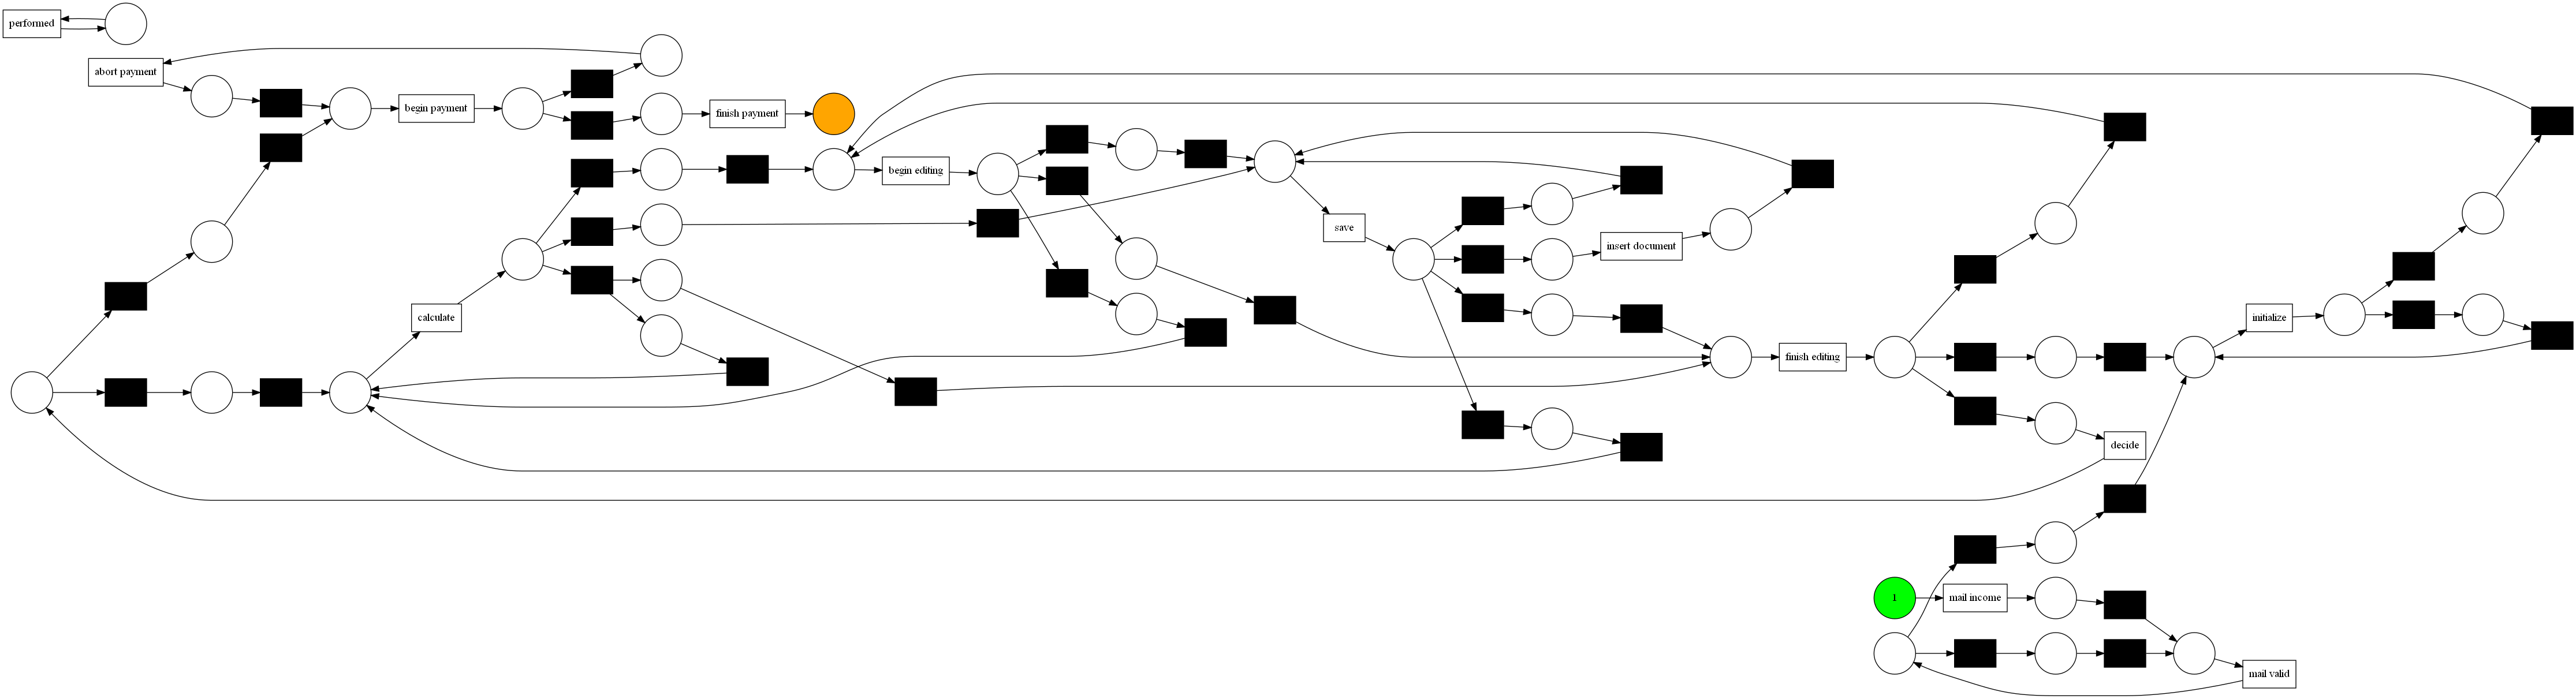

In [18]:
gviz = pn_vis_factory.apply(net, initial_marking, final_marking)
pn_vis_factory.view(gviz)

In [19]:
pnml_exporter.export_net(net, initial_marking, "heuristics_miner_petri.pnml")

## Conformance check Heuristics Miner

In [20]:
start = time.perf_counter()

# fitness based on toked-based replay
fitness = replay_fitness_evaluator.apply(log, net, initial_marking, final_marking, variant=replay_fitness_evaluator.Variants.TOKEN_BASED)

print(f"[ Finished Fitness metric in: {time.perf_counter() - start} sec]")

# precision based on token-based replay
prec = precision_evaluator.apply(log, net, initial_marking, final_marking, variant=precision_evaluator.Variants.ETCONFORMANCE_TOKEN)

print(f"[ Finished Precision metric: {time.perf_counter() - start} sec]")

# generalization based on token-based replay
gen = generalization_evaluator.apply(log, net, initial_marking, final_marking)

print(f"[ Finished Generalization metric: {time.perf_counter() - start} sec]")

# simplicity measured by the inverse arc degree
simp = simplicity_evaluator.apply(net)

print(f"[Finished: {time.perf_counter() - start}]")

[ Finished Fitness metric in: 0.022684899999999786 sec]
[ Finished Precision metric: 0.17003209999999935 sec]
[ Finished Generalization metric: 0.18387689999999957 sec]
[Finished: 0.1845566999999999]


In [21]:
results = [fitness, prec, gen, simp]
with open("heuristics_miner_results.txt", "w") as file:
    for i in range(4):
        file.write(str(results[i]))